In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
with open("new_dumps.txt") as f:
    buf = f.read()

In [3]:
parts = [p for p in  buf.split("START") if p not in [""]]

In [4]:
def dump_to_tuple(dump):
    
    """
    Converts a raw traceroute data-dump into a summarized tuple.
    """
    
    # timestamp
    lines = [l for l in dump.split("\n") if l not in [ "" ] ]
    timestamp = int( lines[0])
    
    # first line (beside the timestamp)
    l1 = lines[1]
    # last line 
    last = lines[-1]
    
    try:
        ip1 = re.match(".*\((.*)\).*", l1).group(1)
        ip2 = re.match(".*\((.*)\).*", last).group(1)
    except:
        pass
    
    # check if target was reached 
    reached = ip1==ip2!=None
    
    # number of hops
    hops = int(last [:4] )
    
    # target latency (ms)
    try:    
        times = re.findall("\d+.\d+ ms", last)
        times = [float(t.replace("ms", "")) for t in times ]
        latency = sum(times)/len(times)
    except:
        latency = None
    
    return (timestamp, hops, reached, latency)

# Convert dumps to dataframe

In [5]:
tuples = [dump_to_tuple(p) for p in parts]

In [6]:
df = pd.DataFrame(tuples, columns=["timestamp", "hops", "reached", "latency_ms"])

## Re-format timestamp

In [7]:
df["timestamp"] = pd.to_datetime(df.timestamp, unit="s")

In [8]:
df = df.set_index("timestamp")

## Compute mean and standard error of metrics over the hour (0-23)



In [9]:
df["hour"] = df.index.hour

In [10]:
df2 = df.groupby("hour").mean()
std_errs = df.groupby("hour").std().rename( columns= {"hops":"hops_std_err", "reached":"reached_std_err", "latency_ms":"latency_ms_std_err"} )
df2 =  df2.merge(std_errs, on="hour")

### Rearrange columns:

In [11]:
df2 = df2[[ "latency_ms", "latency_ms_std_err", "hops", "hops_std_err", "reached", "reached_std_err"  ]]

## Convert GMT to CEST

(Assuming google.it is most accessed from Italy).

In [12]:
df2.index = (df2.index+2)%24

# Plotting Latency

Text(0.5, 1.0, 'LATENCY VS HOUR OF THE DAY/ GOOGLE.IT')

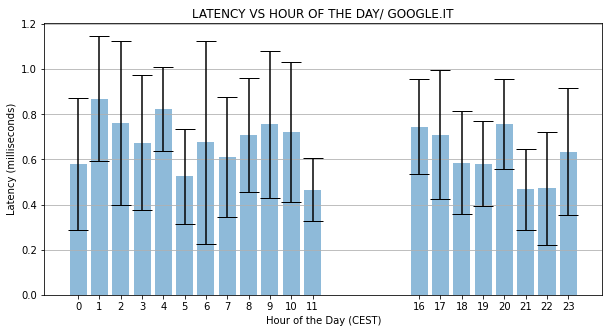

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xticks(df2.index)
ax.bar(df2.index, df2.latency_ms, yerr=df2.latency_ms_std_err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

ax.set_xlabel('Hour of the Day (CEST)')
ax.set_ylabel('Latency (milliseconds)')
ax.set_title('Latency vs Hour of the Day/ google.it'.upper())


# Plotting Hops

Text(0.5, 1.0, 'NUMBER OF HOPS VS HOUR OF THE DAY/ GOOGLE.IT')

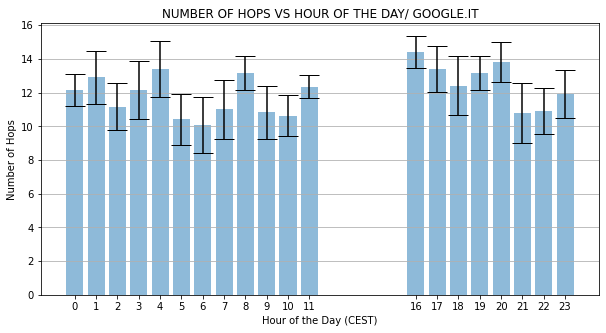

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xticks(df2.index)
ax.bar(df2.index, df2.hops, yerr=df2.hops_std_err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

ax.set_xlabel('Hour of the Day (CEST)')
ax.set_ylabel('Number of Hops')
ax.set_title('Number of Hops vs Hour of the Day/ google.it'.upper())
